In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_datasets as tfds
import datetime
import pickle
import time
from keras.utils.layer_utils import count_params

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, Rescaling, AveragePooling2D

tfk = tf.keras
tfkl = tf.keras.layers

# Data import 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Random seed for reproducibility
seed = 44

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Dataset folders 
dataset_dir = '../gdrive/MyDrive/ann_dataset'
dataset_folder = os.path.join(dataset_dir, 'ann_dataset')

test_folder = os.path.join(dataset_dir, 'test')
train_folder = os.path.join(dataset_dir, 'train')

In [ ]:
IMG_SHAPE = (96,96, 3)

# Functions

In [ ]:
def bottom_model_builder_fully_conv(
    base_model,
    data_augmentation_layer,
    preprocessing_layer = None,
    preprocessing=False,
    data_aug = False):

  inputs=tfk.Input(shape=IMG_SHAPE)
  x = inputs
  if data_aug:
    x = data_augmentation_layer(x)

  if preprocessing:
     x = preprocessing_layer(x)
  x = base_model(x)
  x = tfkl.GlobalAveragePooling2D()(x)

  outputs = tfkl.Dense(
      8, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  return tl_model

# Training Loop

In [ ]:
PATIENCE = 30
EPOCHS = 500
EXPERIMENT_NAME = "efnetB3"

In [ ]:
SELECTED_MODEL = tfk.applications.EfficientNetB5
DROPOUT = 0.0
USE_DATA_AUG = False
FREEZE_PERCENT = 1 # from first filters to Gap (ex 0.1 -> 90% trainable)
REGULARIZER = None #tf.keras.regularizers.l2(0.01)  # applied to conv2d
BATCH_SIZE = 64
PREPROCESSING = None # example -> tf.keras.applications.mobilenet_v2.preprocess_input

# not parameters to set
USE_REG = REGULARIZER is not None
USE_PREPROCESSING = PREPROCESSING is not None

In [ ]:
# data aumentation function default
data_augmentation_layer = Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  ])

In [ ]:
base_model = SELECTED_MODEL(input_shape=IMG_SHAPE,
                            include_top=False,
                            weights='imagenet',
                            drop_connect_rate=DROPOUT)

# just to be sure the model is fully trainable
base_model.trainable = False

115263384/115263384 [==============================] - 6s 0us/step


In [ ]:
# callback list
callbacks_list = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)
callbacks_list.append(es_callback)

In [ ]:
trainable_count = count_params(base_model.trainable_weights)
non_trainable_count = count_params(base_model.non_trainable_weights)
print(f"Before Freeze\nTrainable: \t\t{trainable_count}\nNon Trainable:  \t{non_trainable_count}")

Before Freeze
Trainable: 		0
Non Trainable:  	28513527


In [ ]:
# select percentage to freeze
len_network = len(base_model.layers)
freeze_n = int(len_network * FREEZE_PERCENT)
print(f"netwrok size {len_network} using -> {freeze_n}")

netwrok size 545 using -> 545


In [ ]:
# freeze layers if they are not batch layers
for layer in base_model.layers[:freeze_n]:
  if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
# add regulariazation to conv 2D
# CASPER CODE TO CHECK
if USE_REG:
  for layer in base_model.layers:
      if isinstance(layer, tf.keras.layers.Conv2D):
          layer.kernel_regularizer = REGULARIZER

In [ ]:
trainable_count = count_params(base_model.trainable_weights)
non_trainable_count = count_params(base_model.non_trainable_weights)
print(f"After Freeze\nTrainable: \t\t{trainable_count}\nNon Trainable:  \t{non_trainable_count}")

After Freeze
Trainable: 		0
Non Trainable:  	28513527


In [ ]:
model = bottom_model_builder_fully_conv(
    base_model = base_model,
    data_augmentation_layer = data_augmentation_layer,
    preprocessing_layer=PREPROCESSING,
    data_aug=USE_DATA_AUG,
    preprocessing=USE_PREPROCESSING
    )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb5 (Functional)  (None, 3, 3, 2048)       28513527  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 28,529,919
Trainable params: 16,392
Non-trainable params: 28,513,527
_________________________________________________________________


In [ ]:
# build train and validation dataset and activate prefetching 
train_dataset = tfk.utils.image_dataset_from_directory(
    directory=train_folder,
    labels="inferred",
    label_mode="categorical",
    color_mode='rgb',
    image_size=(96,96),
    batch_size=BATCH_SIZE
)
validation_dataset = tfk.utils.image_dataset_from_directory(
    directory=test_folder,
    labels="inferred",
    label_mode="categorical",
    color_mode='rgb',
    image_size=(96,96),
)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 3624 files belonging to 8 classes.
Found 719 files belonging to 8 classes.


In [ ]:
# Compile model
metrics = [
  tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tfk.losses.CategoricalCrossentropy(), 
    metrics=metrics
    )

In [ ]:
# start training
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = validation_dataset,
    callbacks = callbacks_list,
    ).history

Epoch 1/500
57/57 [==============================] - 26s 228ms/step - loss: 1.6694 - accuracy: 0.3943 - val_loss: 1.5444 - val_accuracy: 0.3978
Epoch 2/500
57/57 [==============================] - 7s 120ms/step - loss: 1.3829 - accuracy: 0.4983 - val_loss: 1.4136 - val_accuracy: 0.4659
Epoch 3/500
57/57 [==============================] - 7s 121ms/step - loss: 1.2686 - accuracy: 0.5348 - val_loss: 1.3379 - val_accuracy: 0.4993
Epoch 4/500
57/57 [==============================] - 7s 121ms/step - loss: 1.1920 - accuracy: 0.5726 - val_loss: 1.2859 - val_accuracy: 0.5146
Epoch 5/500
57/57 [==============================] - 7s 121ms/step - loss: 1.1338 - accuracy: 0.5977 - val_loss: 1.2470 - val_accuracy: 0.5257
Epoch 6/500
57/57 [==============================] - 7s 120ms/step - loss: 1.0870 - accuracy: 0.6159 - val_loss: 1.2163 - val_accuracy: 0.5327
Epoch 7/500
57/57 [==============================] - 7s 120ms/step - loss: 1.0480 - accuracy: 0.6360 - val_loss: 1.1913 - val_accuracy: 0.548

In [ ]:
history_name =  f"history_{EXPERIMENT_NAME}.p"
with open(history_name, "wb" ) as f:
 pickle.dump( history, f)

# to read later
"""with open( "save.p", "rb" ) as f:
 favorite_color = pickle.load(f)"""

'with open( "save.p", "rb" ) as f:\n favorite_color = pickle.load(f)'

In [ ]:
model_name = f"Model_{EXPERIMENT_NAME}"
model.save(model_name)

In [ ]:
from google.colab import files
files.download(history_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(model_name)

# Plots

22/22 [==============================] - 3s 33ms/step


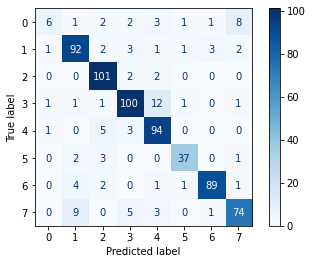

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# model = tfk.models.load_model("../gdrive/MyDrive/experiments/CNN10_3_fold")

Y_pred = model.predict(validation_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_test= np.concatenate([np.argmax(y, axis=1) for x, y in validation_dataset], axis=0)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

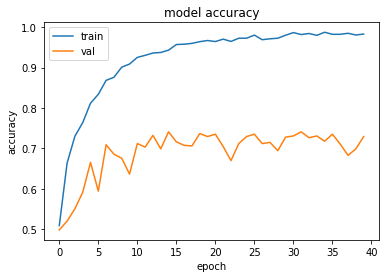

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

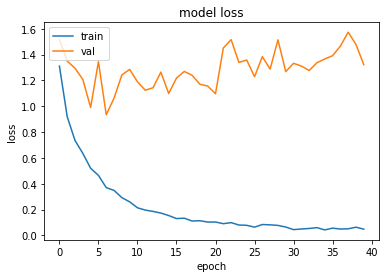

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
np.max(model.history.history['val_accuracy'])